#Using BERT

##importing libraries

In [1]:
!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

     |████████████████████████████████| 4.4 MB 5.3 MB/s 


##Data Preprocessing

In [2]:
import pandas as pd
df = pd.read_csv('/content/data.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby(by='Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

The dataset is skewed towards one class, an imbalanced dataset. There are several ways to deal with this kind of problems.
(1)Oversampling:- In which we oversample the examples of a class which has less samples.
(2)Downsampling:- In which we Downsample(means removing examples) the class which has large samples.

Since BERT is a powerfull and complex model which has millions of parameteres to be trained during the training mode, we will be using second option to deal with this problem.

In [7]:
df.Category.value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [12]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [13]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [14]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [15]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [16]:
df_balanced = df_balanced.sample(frac=1)

In [18]:
#add the dependent variable from the categorical variable.
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
236,ham,I have printed it oh. So &lt;#&gt; come upst...,0
3283,ham,Hey you around? I've got enough for a half + t...,0
2867,ham,Smith waste da.i wanna gayle.,0
283,ham,Ok. I asked for money how far,0
4158,ham,This single single answers are we fighting? Pl...,0


In [19]:
#Spilitting the dataset into train, test and validation.
from sklearn.model_selection import train_test_split
X_train, X_rem, y_train, y_rem = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'], train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, stratify=y_rem, test_size=0.5)

##Getting the BERT model from tensorflow_hub

In [20]:
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [21]:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435166 , -0.5132724 , -0.88845706, ..., -0.7474883 ,
        -0.7531471 ,  0.91964483],
       [-0.8720836 , -0.50544   , -0.9444667 , ..., -0.8584748 ,
        -0.71745366,  0.88082993]], dtype=float32)>

##Building + Training + Evaluating a custom model using BERT

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [23]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_accuracy') >= 0.92):
      model.stop_training = True

MyCallBack_Object = MyCallback()

In [24]:
METRICS = [tf.keras.metrics.BinaryAccuracy(name='accuracy')]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=35, callbacks=[MyCallBack_Object])

Epoch 1/35
38/38 [==============================] - 37s 708ms/step - loss: 0.6075 - accuracy: 0.6937 - val_loss: 0.5222 - val_accuracy: 0.8255
Epoch 2/35
38/38 [==============================] - 26s 683ms/step - loss: 0.4847 - accuracy: 0.8310 - val_loss: 0.4234 - val_accuracy: 0.8993
Epoch 3/35
38/38 [==============================] - 26s 682ms/step - loss: 0.4173 - accuracy: 0.8695 - val_loss: 0.3763 - val_accuracy: 0.8859
Epoch 4/35
38/38 [==============================] - 26s 681ms/step - loss: 0.3754 - accuracy: 0.8812 - val_loss: 0.3419 - val_accuracy: 0.8993
Epoch 5/35
38/38 [==============================] - 26s 679ms/step - loss: 0.3432 - accuracy: 0.8895 - val_loss: 0.3223 - val_accuracy: 0.8792
Epoch 6/35
38/38 [==============================] - 26s 678ms/step - loss: 0.3184 - accuracy: 0.8962 - val_loss: 0.3033 - val_accuracy: 0.8926
Epoch 7/35
38/38 [==============================] - 26s 679ms/step - loss: 0.3087 - accuracy: 0.9046 - val_loss: 0.2900 - val_accuracy: 0.9128

In [26]:
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(val_accuracy)

5/5 [==============================] - 3s 560ms/step - loss: 0.2474 - accuracy: 0.9200
0.9200000166893005


In [27]:
import numpy as np
y_predicted = np.where(model.predict(X_test).flatten() > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0])

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
print(cm)
print(classification_report(y_test, y_predicted))

[[74  1]
 [11 64]]
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.98      0.85      0.91        75

    accuracy                           0.92       150
   macro avg       0.93      0.92      0.92       150
weighted avg       0.93      0.92      0.92       150



Text(33.0, 0.5, 'Truth')

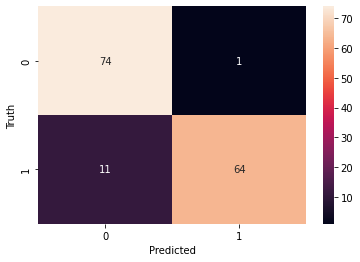

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your .",
    "I will not be available for today."
    ]
model.predict(reviews)

array([[0.749148  ],
       [0.8735401 ],
       [0.7327405 ],
       [0.10120992],
       [0.04414837],
       [0.08082779]], dtype=float32)